<a href="https://colab.research.google.com/github/kkipngenokoech/MI/blob/main/MI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## INSTALLS

In [1]:
!wget https://media.githubusercontent.com/media/kkipngenokoech/MI/refs/heads/main/smrdata.zip -O smrdata.zip
!unzip smrdata.zip > /dev/null 2>&1
%cd smrdata
!pip install mne

--2025-11-18 12:22:39--  https://media.githubusercontent.com/media/kkipngenokoech/MI/refs/heads/main/smrdata.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1540873695 (1.4G) [application/zip]
Saving to: ‘smrdata.zip’

smrdata.zip         100%[===================>]   1.43G  66.8MB/s    in 19s     

2025-11-18 12:22:59 (76.0 MB/s) - ‘smrdata.zip’ saved [1540873695/1540873695]

/content/smrdata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 58.8 MB/s eta 0:00:00


## IMPORTS & CONFIG

In [25]:
import os
import numpy as np
import scipy.io as sio
from scipy.signal import butter, filtfilt, welch
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score, confusion_matrix
from mne.decoding import CSP

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, Activation,
    GlobalAveragePooling1D, Dropout, Dense
)
from tensorflow.keras.optimizers import Adam


## DATASET LOADING

In [3]:
def load_raw_runs(session_dirs):
    runs = []
    for sd in session_dirs:
        files = sorted([f for f in os.listdir(sd) if f.endswith(".mat")])
        for fn in files:
            d = sio.loadmat(os.path.join(sd, fn))["runData"][0,0]
            runs.append({
                "fs": int(d["fs"][0,0]),
                "X": d["allData"],
                "labels": [str(x[0]) for x in d["label"].flatten()],
                "ts": d["trialStart"].flatten().astype(int),
                "target": d["target"].flatten(),     # contains 1,2,3,4
                "outcome": d["outcome"].flatten(),
                "session": sd,
                "file": fn
            })
    return runs

In [4]:
session_dirs = ["Session1","Session2"]
runs = load_raw_runs(session_dirs)

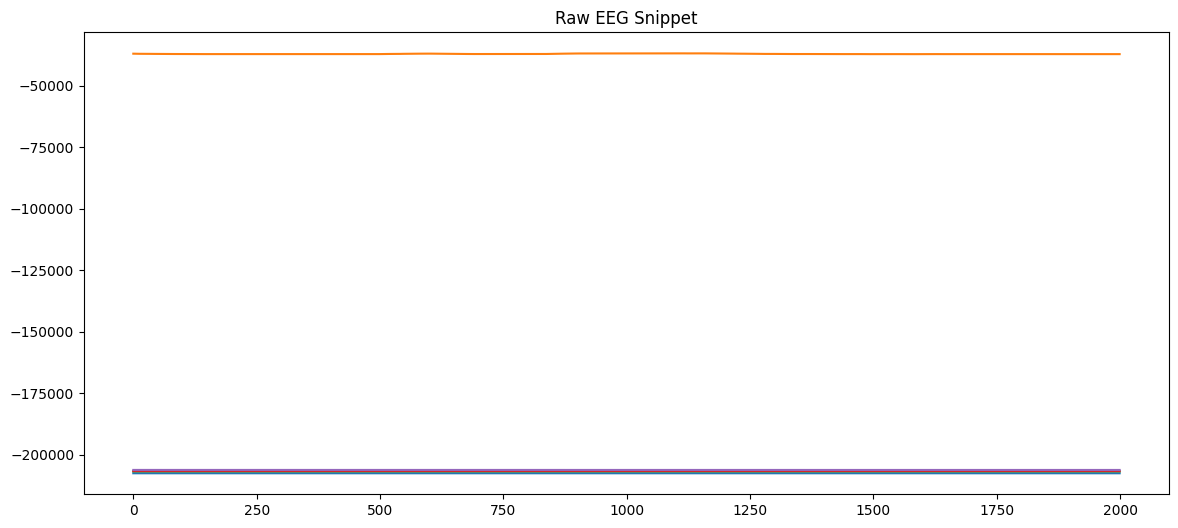

In [5]:
def plot_raw_signal(X, labels, n=2000):
    plt.figure(figsize=(14,6))
    for i in range(min(5, X.shape[0])):
        plt.plot(X[i,:n] + i*200, label=labels[i])
    plt.title("Raw EEG Snippet")
    plt.show()
plot_raw_signal(runs[0]["X"], runs[0]["labels"])


## CHANNEL SELECTION

In [6]:
ACTIVE_LABELS = [
    'F3','F4','Fc5','Fc3','Fc1','Fcz','Fc2','Fc4','Fc6',
    'T7','C5','C3','C1','Cz','C2','C4','C6','T8',
    'Cp5','Cp3','Cp1','Cpz','Cp2','Cp4','Cp6','P3','P4'
]

def pick_channels(run):
    idx = [i for i,l in enumerate(run["labels"]) if l in ACTIVE_LABELS]
    X = run["X"][idx,:]
    labels = [run["labels"][i] for i in idx]
    return X, labels




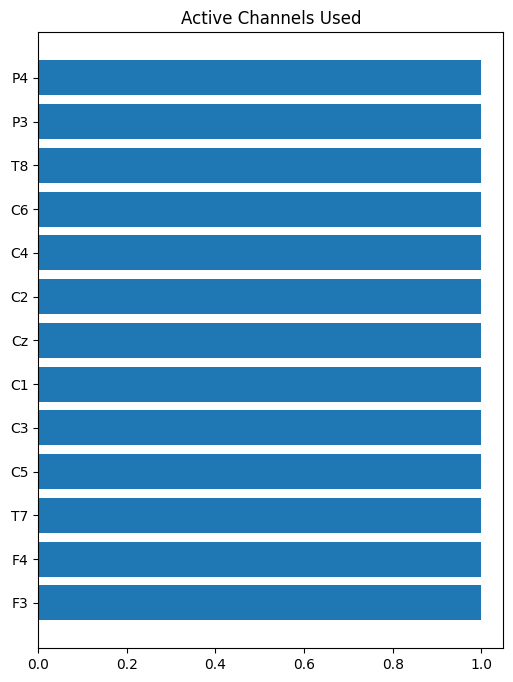

In [7]:
def plot_selected_channels(labels):
    plt.figure(figsize=(6,8))
    plt.barh(range(len(labels)), np.ones(len(labels)))
    plt.yticks(range(len(labels)), labels)
    plt.title("Active Channels Used")
    plt.show()
Xsel, ch_labels = pick_channels(runs[0])
plot_selected_channels(ch_labels)


## FILTERING

In [8]:
def bandpass(X, low, high, fs):
    b, a = butter(4, [low/(fs/2), high/(fs/2)], btype='band')
    return filtfilt(b, a, X, axis=1)

def preprocess_filter(X, fs, low=8, high=30, down=4):
    Xf = bandpass(X, low, high, fs)
    Xd = Xf[:, ::down]
    fs_new = fs/down
    Xcar = Xd - Xd.mean(axis=0, keepdims=True)
    return Xcar, fs_new


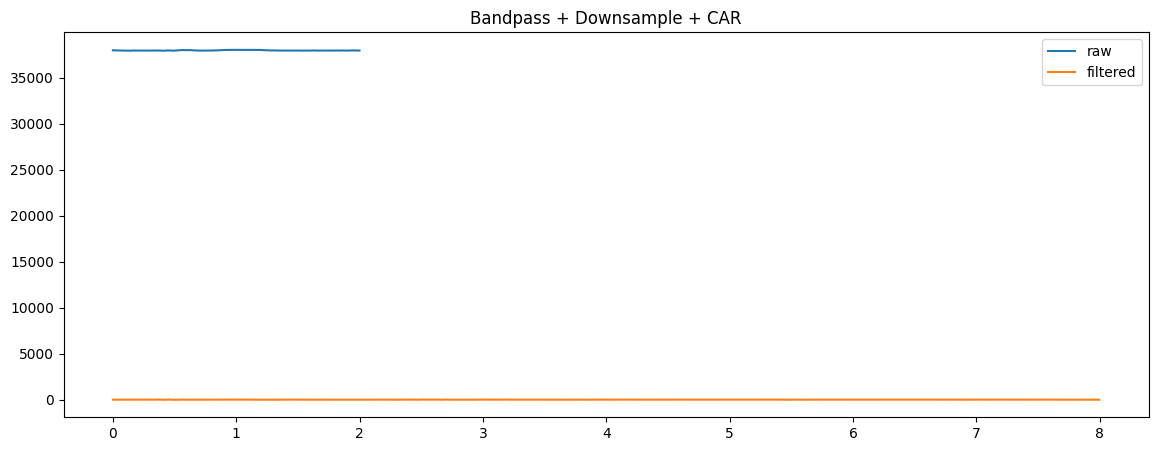

In [9]:
## FILTER DEMO
def plot_filter_demo(raw, clean, fs, fs_new, ch=0, n=2000):
    plt.figure(figsize=(14,5))
    plt.plot(np.arange(n)/fs, raw[ch,:n], label='raw')
    plt.plot(np.arange(n)/fs_new, clean[ch,:n], label='filtered')
    plt.legend()
    plt.title("Bandpass + Downsample + CAR")
    plt.show()
raw = runs[0]["X"][0:1]  # channel slice
clean, _ = preprocess_filter(Xsel, runs[0]["fs"])
DOWNSAMPLE = 4
plot_filter_demo(Xsel, clean, runs[0]["fs"], runs[0]["fs"]/DOWNSAMPLE)

## EPOCH EXTRACTION

In [10]:
def epoch_run(X, ts, target, outcome, fs_orig, fs_new, epoch_win):
    ep_list = []
    lb_list = []
    length = int((epoch_win[1]-epoch_win[0]) * fs_new)

    for i, s in enumerate(ts):
        if outcome[i] == 0:
            continue
        start = int((s/fs_orig + epoch_win[0]) * fs_new)
        end   = start + length
        if start < 0 or end > X.shape[1]:
            continue
        ep_list.append(X[:, start:end])
        lb_list.append(int(target[i]))   # 1..4
    return np.array(ep_list), np.array(lb_list)


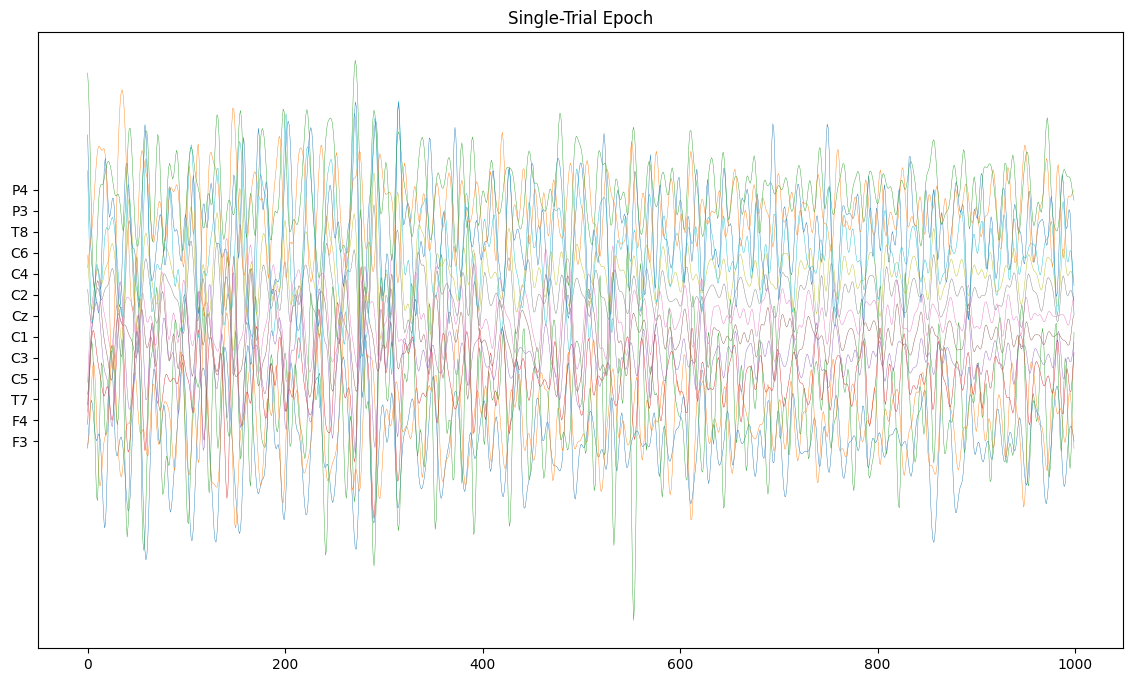

In [11]:
def plot_epoch_stack(ep, ch_labels):
    plt.figure(figsize=(14,8))
    scale = 2
    for i in range(ep.shape[0]):
        plt.plot(ep[i] + i*scale, linewidth=0.3)
    plt.yticks(np.arange(ep.shape[0])*scale, ch_labels)
    plt.title("Single-Trial Epoch")
    plt.show()
ep, lb = epoch_run(clean, runs[0]["ts"], runs[0]["target"],
                   runs[0]["outcome"], runs[0]["fs"],
                   runs[0]["fs"]/DOWNSAMPLE, (-2,2))

plot_epoch_stack(ep[0], ch_labels)



## BASELINE CORRECTION

In [12]:
def baseline_correct(ep, fs_new, epoch_win, base_win):
    b0 = int((base_win[0] - epoch_win[0]) * fs_new)
    b1 = int((base_win[1] - epoch_win[0]) * fs_new)
    base = ep[:,:,b0:b1].mean(axis=2, keepdims=True)
    return ep - base


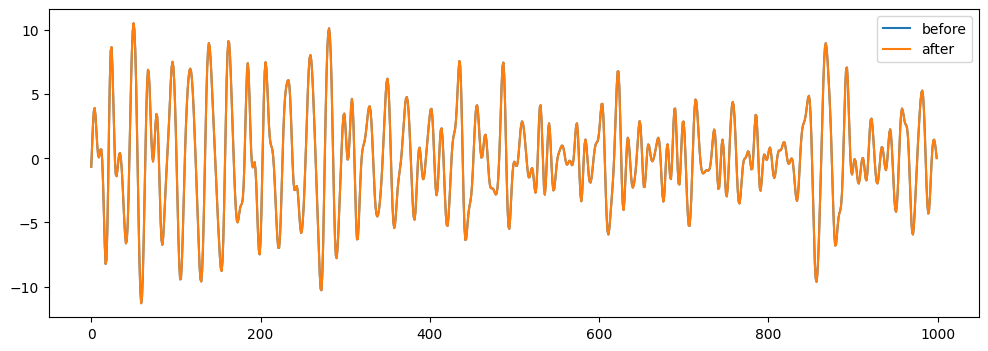

In [13]:
def plot_baseline_effect(ep0, ep1, ch=0):
    plt.figure(figsize=(12,4))
    plt.plot(ep0[ch], label='before')
    plt.plot(ep1[ch], label='after')
    plt.legend()
    plt.show()
ep0 = ep.copy()
ep1 = baseline_correct(ep, runs[0]["fs"]/DOWNSAMPLE, (-2,2), (-2,0))
plot_baseline_effect(ep0[0], ep1[0])

## AGGREGATING ALL SESSIONS

In [14]:
def preprocess_all_runs(runs):
    all_ep = []
    all_lb = []
    fs_new_global = None
    L = None

    for run in runs:
        Xsel, chan_labels = pick_channels(run)
        Xclean, fs_new = preprocess_filter(Xsel, run["fs"])
        ep, lb = epoch_run(
            Xclean, run["ts"], run["target"], run["outcome"],
            fs_orig=run["fs"], fs_new=fs_new,
            epoch_win=(-2,2)
        )
        if ep.size == 0:
            continue

        ep = baseline_correct(ep, fs_new, (-2,2), (-2,0))

        if L is None:
            L = ep.shape[2]
            fs_new_global = fs_new
        else:
            m = min(L, ep.shape[2])
            ep = ep[:,:,:m]
            L = m

        all_ep.append(ep)
        all_lb.append(lb)

    X_all = np.concatenate(all_ep, axis=0)
    y_all = np.concatenate(all_lb).astype(int) - 1   # → 0..3
    return X_all, y_all, fs_new_global, chan_labels


X_all, y_all, fs_new, ch_labels = preprocess_all_runs(runs)


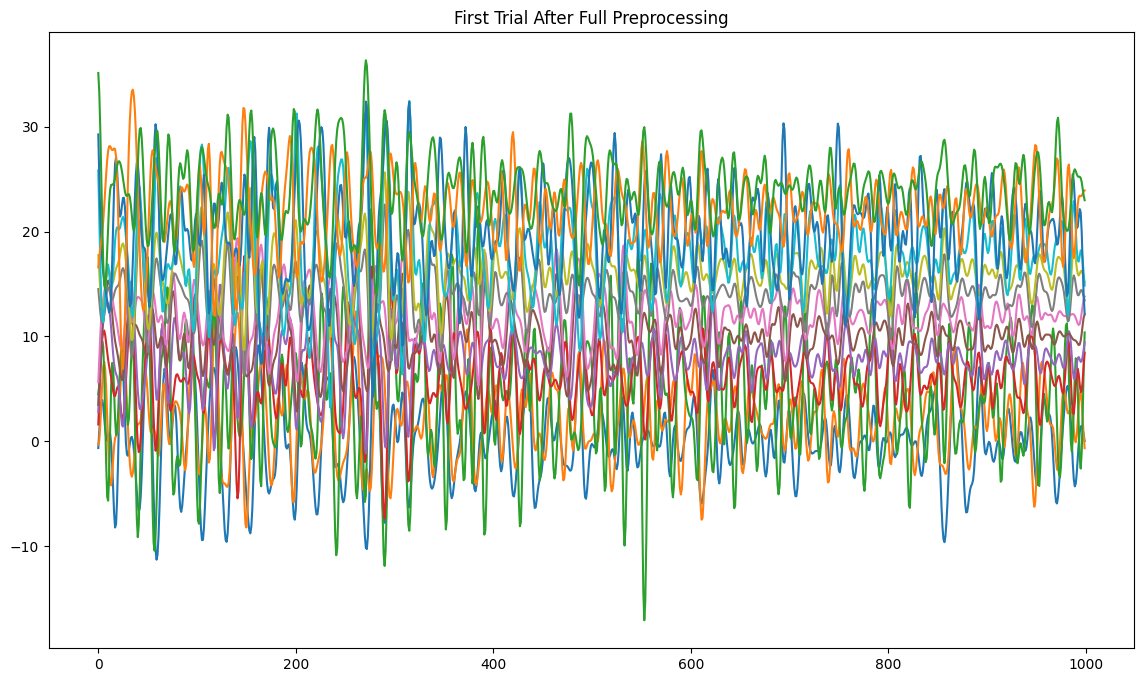

In [15]:
plt.figure(figsize=(14,8))
for i in range(X_all.shape[1]):
    plt.plot(X_all[0,i] + i*2)
plt.title("First Trial After Full Preprocessing")
plt.show()


## BANDPOWER FEATURES

In [16]:
def bandpower_epochs(ep, fs, bands=[(8,12),(13,30)]):
    out = []
    for tr in range(ep.shape[0]):
        ft = []
        for ch in range(ep.shape[1]):
            f, Pxx = welch(ep[tr,ch], fs=fs, nperseg=min(256, ep.shape[2]))
            for (lo,hi) in bands:
                idx = (f>=lo)&(f<=hi)
                ft.append(Pxx[idx].mean())
        out.append(ft)
    return np.array(out)

X_bp = bandpower_epochs(X_all, fs_new)

## CSP (ONE VRS REST) + LDA

In [17]:
def multiclass_csp(ep, y, n_comp=4):
    classes = np.unique(y)
    feats = []
    for c in classes:
        csp = CSP(n_components=n_comp, reg='shrinkage', log=True)
        yc = (y==c).astype(int)
        F = csp.fit_transform(ep, yc)
        feats.append(F)
    return np.concatenate(feats, axis=1)


In [34]:
def eval_classical(X, y):
    skf = StratifiedKFold(5, shuffle=True, random_state=42)
    accs = []
    for tr, te in skf.split(X,y):
        clf = LDA()
        clf.fit(X[tr], y[tr])
        ypred = clf.predict(X[te])
        accs.append(accuracy_score(y[te], ypred))
    return np.mean(accs), np.std(accs)

X_bp = bandpower_epochs(X_all, fs_new)
bp_mean, bp_std = eval_classical(X_bp, y_all)
bp_lda_mean, bp_lda_std = eval_classical(X_bp, y_all)
X_csp = multiclass_csp(X_all, y_all)
csp_mean, csp_std = eval_classical(X_csp, y_all)
print("CSP:", csp_mean, csp_std)
print("Bandpower:", bp_mean, bp_std)


Computing rank from data with rank=None
    Using tolerance 17 (2.2e-16 eps * 13 dim * 5.8e+15  max singular value)
    Estimated rank (data): 13
    data: rank 13 computed from 13 data channels with 0 projectors
Reducing data rank from 13 -> 13
Estimating class=0 covariance using SHRINKAGE
Done.
Estimating class=1 covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 17 (2.2e-16 eps * 13 dim * 5.8e+15  max singular value)
    Estimated rank (data): 13
    data: rank 13 computed from 13 data channels with 0 projectors
Reducing data rank from 13 -> 13
Estimating class=0 covariance using SHRINKAGE
Done.
Estimating class=1 covariance using SHRINKAGE
Done.
CSP: 0.6131872852233676 0.04328071560303972
Bandpower: 0.5924828178694158 0.0366403143498547


## BANDPOWER + SVM

In [18]:
# -------------------------
# Bandpower + SVM
# -------------------------
from sklearn.svm import SVC

def eval_svm(X, y):
    cv = StratifiedKFold(5, shuffle=True, random_state=42)
    accs = []
    cms = []
    for tr, te in cv.split(X, y):
        clf = SVC(kernel="linear", probability=False)
        clf.fit(X[tr], y[tr])
        y_pred = clf.predict(X[te])
        accs.append(accuracy_score(y[te], y_pred))
        cms.append(confusion_matrix(y[te], y_pred, labels=np.unique(y)))
    return np.mean(accs), np.std(accs), cms

bp_svm_mean, bp_svm_std, bp_svm_cms = eval_svm(X_bp, y_all)

print("Bandpower + SVM: %.2f%% ± %.2f%%" %
      (bp_svm_mean*100, bp_svm_std*100))


Bandpower + SVM: 56.97% ± 2.41%


## CNN

In [19]:
def build_cnn(input_shape, n_classes):
    m = Sequential([
        Input(shape=input_shape),
        Conv1D(16,64,padding='same'), BatchNormalization(), Activation('relu'),
        Conv1D(32,32,padding='same'), BatchNormalization(), Activation('relu'),
        GlobalAveragePooling1D(),
        Dropout(0.5),
        Dense(n_classes, activation='softmax')
    ])
    m.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return m


In [20]:
def eval_cnn(ep, y, build_fn):
    X = ep.transpose(0,2,1).astype('float32')
    n_samples, n_channels = X.shape[1], X.shape[2]
    n_classes = len(np.unique(y))

    skf = StratifiedKFold(5, shuffle=True, random_state=42)
    accs = []
    for tr, te in skf.split(X,y):
        model = build_fn((n_samples,n_channels), n_classes)
        model.fit(X[tr], y[tr], epochs=35, batch_size=16, validation_split=0.1, verbose=0)
        pred = np.argmax(model.predict(X[te], verbose=0), axis=1)
        accs.append(accuracy_score(y[te], pred))
        tf.keras.backend.clear_session()
    return np.mean(accs), np.std(accs)


In [21]:
cnn_mean, cnn_std = eval_cnn(X_all, y_all, build_cnn)
print("CNN: %.2f%% ± %.2f%%" % (cnn_mean*100, cnn_std*100))

CNN: 65.69% ± 4.04%


## EEGNET

In [23]:
def build_eegnet_like(input_shape, n_classes):
    model = Sequential([
        Input(shape=input_shape),

        # temporal filtering
        Conv1D(8, kernel_size=64, padding='same'),
        BatchNormalization(),
        Activation('elu'),

        # depth-wise style layer (not true EEGNet, but lightweight variant)
        Conv1D(16, kernel_size=16, padding='same'),
        BatchNormalization(),
        Activation('elu'),

        GlobalAveragePooling1D(),
        Dropout(0.5),
        Dense(n_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [26]:
eegnet_mean, eegnet_std = eval_cnn(X_all, y_all, build_eegnet_like)
print("EEGNet-like:", eegnet_mean, eegnet_std)

print("EEGNET: %.2f%% ± %.2f%%" % (eegnet_mean*100, eegnet_std*100))

EEGNet-like: 0.6466065292096219 0.052833279172909905
EEGNET: 64.66% ± 5.28%


## ONLINE DECODING ACCURACY

In [28]:
def pvc(target, outcome):
    valid = outcome != 0       # ignore aborts
    hits  = outcome == 1
    return hits[valid].mean()


### PVC per task type

In [29]:
def pvc_by_task(run):
    tar = run["target"].flatten()
    out = run["outcome"].flatten()

    lr_idx = np.where((tar == 1) | (tar == 2))[0]
    ud_idx = np.where((tar == 3) | (tar == 4))[0]

    pvc_lr = pvc(tar[lr_idx], out[lr_idx]) if len(lr_idx) > 0 else None
    pvc_ud = pvc(tar[ud_idx], out[ud_idx]) if len(ud_idx) > 0 else None

    return pvc_lr, pvc_ud

for i, r in enumerate(runs):
    lr, ud = pvc_by_task(r)
    print(f"Session {i+1}:  LR PVC = {lr},  UD PVC = {ud}")


Session 1:  LR PVC = 0.5882352941176471,  UD PVC = None
Session 2:  LR PVC = 0.5,  UD PVC = None
Session 3:  LR PVC = 0.6,  UD PVC = None
Session 4:  LR PVC = 0.6428571428571429,  UD PVC = None
Session 5:  LR PVC = 0.5,  UD PVC = None
Session 6:  LR PVC = 0.35294117647058826,  UD PVC = None
Session 7:  LR PVC = 0.6666666666666666,  UD PVC = None
Session 8:  LR PVC = 0.5714285714285714,  UD PVC = None
Session 9:  LR PVC = 0.4166666666666667,  UD PVC = None
Session 10:  LR PVC = 0.5714285714285714,  UD PVC = None
Session 11:  LR PVC = 0.55,  UD PVC = None
Session 12:  LR PVC = 0.3888888888888889,  UD PVC = None
Session 13:  LR PVC = 0.47368421052631576,  UD PVC = None
Session 14:  LR PVC = 0.47619047619047616,  UD PVC = None
Session 15:  LR PVC = 0.65,  UD PVC = None
Session 16:  LR PVC = 0.7142857142857143,  UD PVC = None
Session 17:  LR PVC = 0.7857142857142857,  UD PVC = None
Session 18:  LR PVC = 0.6428571428571429,  UD PVC = None
Session 19:  LR PVC = 0.8,  UD PVC = None
Session 20:

### PVC per session

In [30]:
for i, r in enumerate(runs):
    pvc_i = pvc(r["target"], r["outcome"])
    print(f"Session {i+1} PVC: {pvc_i:.3f}")


Session 1 PVC: 0.588
Session 2 PVC: 0.500
Session 3 PVC: 0.600
Session 4 PVC: 0.643
Session 5 PVC: 0.500
Session 6 PVC: 0.353
Session 7 PVC: 0.667
Session 8 PVC: 0.571
Session 9 PVC: 0.417
Session 10 PVC: 0.571
Session 11 PVC: 0.550
Session 12 PVC: 0.389
Session 13 PVC: 0.474
Session 14 PVC: 0.476
Session 15 PVC: 0.650
Session 16 PVC: 0.714
Session 17 PVC: 0.786
Session 18 PVC: 0.643
Session 19 PVC: 0.800
Session 20 PVC: 0.333
Session 21 PVC: 0.786
Session 22 PVC: 0.381
Session 23 PVC: 0.316
Session 24 PVC: 0.400
Session 25 PVC: 0.412
Session 26 PVC: 0.450
Session 27 PVC: 0.400
Session 28 PVC: 0.316


### Overall PVC

In [31]:
def overall_pvc(runs):
    all_targets  = []
    all_outcomes = []

    for r in runs:
        all_targets.append(r["target"].flatten())
        all_outcomes.append(r["outcome"].flatten())

    all_targets  = np.concatenate(all_targets)
    all_outcomes = np.concatenate(all_outcomes)

    valid = all_outcomes != 0
    hits  = all_outcomes == 1

    return hits[valid].mean()

global_pvc = overall_pvc(runs)
print("Overall Online PVC:", global_pvc)


Overall Online PVC: 0.5093167701863354


## COMPARISION

In [35]:
results = {
    "Online PVC": global_pvc,

    "Bandpower + LDA (PVC)": (bp_lda_mean, bp_lda_std),
    "Bandpower + SVM (PVC)": (bp_svm_mean, bp_svm_std),

    "CSP + LDA (PVC)": (csp_mean, csp_std),

    "1D-CNN (PVC)": (cnn_mean, cnn_std),
    "EEGNet-like (PVC)": (eegnet_mean, eegnet_std),
}

for k, v in results.items():
    print(k, ":", v)


Online PVC : 0.5093167701863354
Bandpower + LDA (PVC) : (np.float64(0.5924828178694158), np.float64(0.0366403143498547))
Bandpower + SVM (PVC) : (np.float64(0.5696520618556701), np.float64(0.02412999931512061))
CSP + LDA (PVC) : (np.float64(0.6131872852233676), np.float64(0.04328071560303972))
1D-CNN (PVC) : (np.float64(0.6569158075601375), np.float64(0.04044030116454028))
EEGNet-like (PVC) : (np.float64(0.6466065292096219), np.float64(0.052833279172909905))


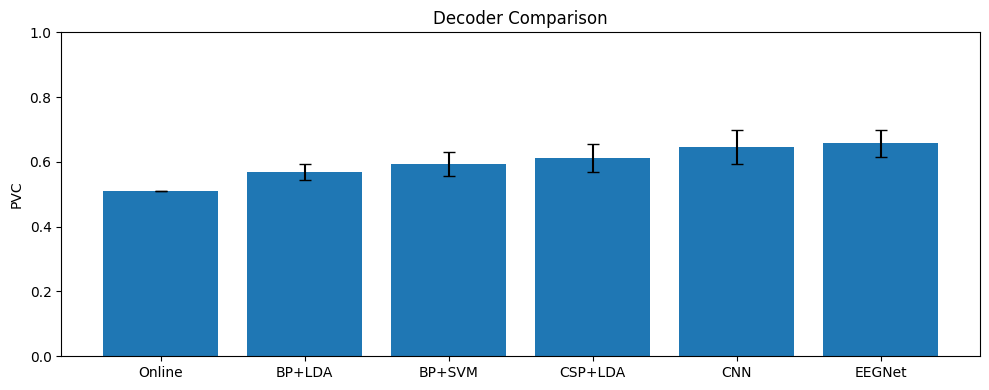

In [38]:
import matplotlib.pyplot as plt
import numpy as np

names = [
    "Online",
    "BP+LDA",
    "BP+SVM",
    "CSP+LDA",
    "CNN",
    "EEGNet"
]

means = [
    global_pvc,
    bp_svm_mean,
    bp_lda_mean,
    csp_mean,
    eegnet_mean,
    cnn_mean
]

errs = [
    0,
    bp_svm_std,
    bp_lda_std,
    csp_std,
    eegnet_std,
    cnn_std
]

x = np.arange(len(names))

plt.figure(figsize=(10,4))
plt.bar(x, means, yerr=errs, capsize=4)
plt.xticks(x, names, rotation=0)
plt.ylabel("PVC")
plt.ylim(0,1)
plt.title("Decoder Comparison")
plt.tight_layout()
plt.show()
